link: https://www.kaggle.com/lava18/google-play-store-apps

**Using different algorithms to predict Apps’ Rating and comparing to find the best model.**

In [1]:
#packages:

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
import random
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

#preprocessing:
from sklearn import preprocessing
#Encoding: LabelEncoder
#Scaling: MinMaxScaler, RobustScaler

#modeling:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score

import re
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import files  
uploaded = files.upload()

Saving archive.zip to archive.zip


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('archive.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

app=pd.read_csv('/content/files/googleplaystore.csv')

In [3]:
app.drop(app.loc[app['Installs']=='Free'].index, inplace=True)
app.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Dataset detils:

In [4]:
app.shape

(10840, 13)

In [5]:
app.info

<bound method DataFrame.info of                                                      App  ...         Android Ver
0         Photo Editor & Candy Camera & Grid & ScrapBook  ...        4.0.3 and up
1                                    Coloring book moana  ...        4.0.3 and up
2      U Launcher Lite – FREE Live Cool Themes, Hide ...  ...        4.0.3 and up
3                                  Sketch - Draw & Paint  ...          4.2 and up
4                  Pixel Draw - Number Art Coloring Book  ...          4.4 and up
...                                                  ...  ...                 ...
10836                                   Sya9a Maroc - FR  ...          4.1 and up
10837                   Fr. Mike Schmitz Audio Teachings  ...          4.1 and up
10838                             Parkinson Exercices FR  ...          2.2 and up
10839                      The SCP Foundation DB fr nn5n  ...  Varies with device
10840      iHoroscope - 2018 Daily Horoscope & Astrology  ...  Var

In [6]:
app.describe()

,Rating
count,9366.000000
mean,4.191757
std,0.515219
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,5.000000


# 1. MINIMAL PREPROCESSING:

1. Checking missing values:

In [7]:
app.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

<Figure size 720x720 with 0 Axes>

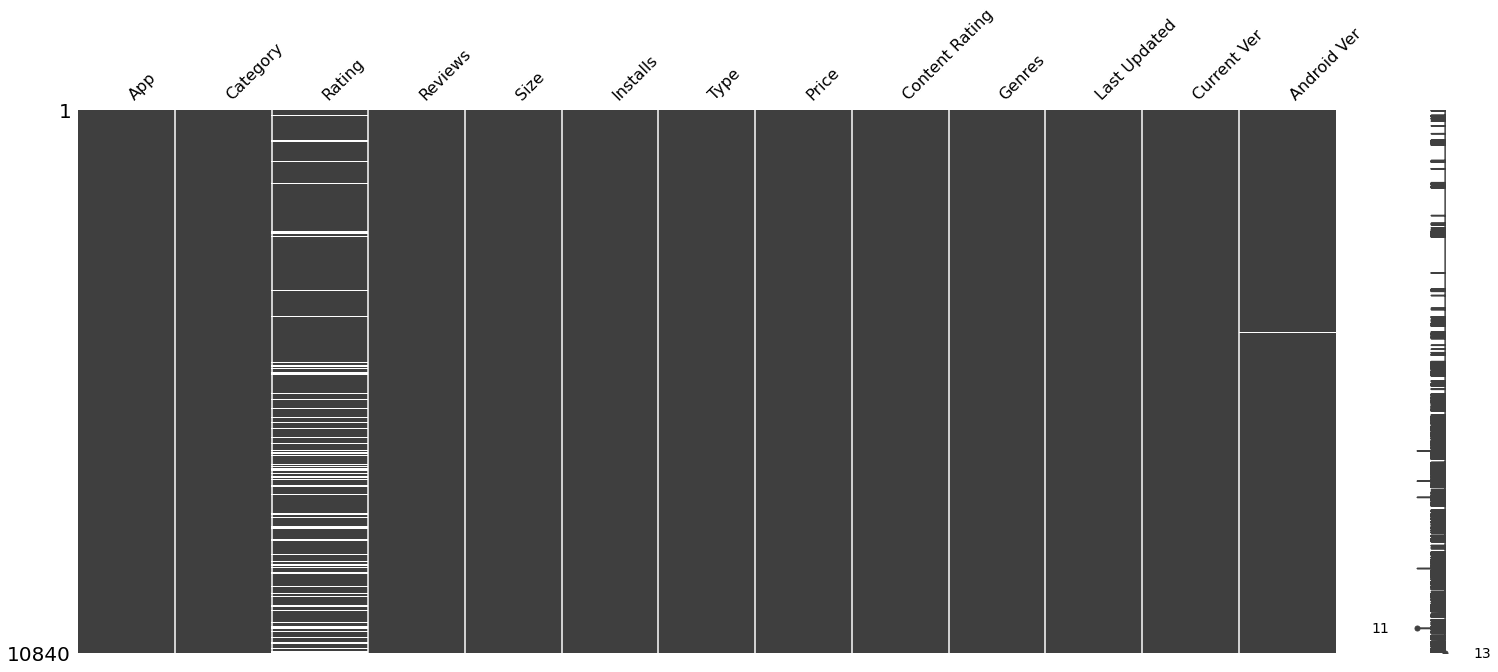

In [8]:
plt.figure(figsize = (10,10))
msno.matrix(app)

1.1 Handling missing values 


In [9]:
app=pd.read_csv('/content/files/googleplaystore.csv')
app.drop(app.loc[app['Installs']=='Free'].index, inplace=True)

In [10]:
#catagorical data:
app.select_dtypes(include='object').isnull().sum()

App               0
Category          0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       8
Android Ver       2
dtype: int64

In [11]:
app['Type'].fillna(str(app.Type.mode().values[0]), inplace=True)
app['Current Ver'].fillna(str(app['Current Ver'].mode().values[0]), inplace=True)
app['Android Ver'].fillna(str(app['Android Ver'].mode().values[0]), inplace=True)

In [12]:
app.select_dtypes(include='object').isnull().sum()

App               0
Category          0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

1.2. Data Normalization (Feature Scalling)

In [13]:
# Cleaning Categories into integers
CategoryString = app["Category"]
categoryVal = app["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0,categoryValCount):
    category_dict[categoryVal[i]] = i
app["Category_c"] = app["Category"].map(category_dict).astype(int)
app["Category_c"].describe()

count    10840.000000
mean        17.665129
std          7.481603
min          0.000000
25%         13.000000
50%         18.000000
75%         23.000000
max         32.000000
Name: Category_c, dtype: float64

In [14]:
#scaling size of installation
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

app["Size"] = app["Size"].map(change_size)
app["Size"].head()

0    19000000.0
1    14000000.0
2     8700000.0
3    25000000.0
4     2800000.0
Name: Size, dtype: float64

In [15]:
#Cleaning number of installs classification

app['Installs'] = [re.sub('[\,+]', '', i) for i in app['Installs']]
app['Installs'] = app['Installs'].astype(int)
app['Installs'].head()

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: int64

In [16]:
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

app['Type'] = app['Type'].map(type_cat)
app['Type'].describe()

count    10840.000000
mean         0.073801
std          0.261458
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Type, dtype: float64

In [17]:
#Cleaning of content rating classification
RatingL = app['Content Rating'].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
app['Content Rating'] = app['Content Rating'].map(RatingDict).astype(int)
app['Content Rating'].describe()

count    10840.000000
mean         0.327952
std          0.761608
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: Content Rating, dtype: float64

In [18]:
#dropping of unrelated and unnecessary items
app.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [19]:
app['Genres_'] = app['Genres'].str.split(';').str[0]
app['Genres_'].unique()

array(['Art & Design', 'Auto & Vehicles', 'Beauty', 'Books & Reference',
       'Business', 'Comics', 'Communication', 'Dating', 'Education',
       'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Adventure', 'Arcade', 'Casual', 'Card', 'Action',
       'Strategy', 'Puzzle', 'Sports', 'Music', 'Word', 'Racing',
       'Simulation', 'Board', 'Trivia', 'Role Playing', 'Educational',
       'Music & Audio', 'Video Players & Editors', 'Medical', 'Social',
       'Shopping', 'Photography', 'Travel & Local', 'Tools',
       'Personalization', 'Productivity', 'Parenting', 'Weather',
       'News & Magazines', 'Maps & Navigation', 'Casino'], dtype=object)

In [20]:
app_cat = pd.get_dummies(app, columns=['Category'])
app_cat.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres_,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,4.1,159,19000000.0,10000,0,0,0,Art & Design,0,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14000000.0,500000,0,0,0,Art & Design;Pretend Play,0,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8700000.0,5000000,0,0,0,Art & Design,0,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25000000.0,50000000,0,0,1,Art & Design,0,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2800000.0,100000,0,0,0,Art & Design;Creativity,0,Art & Design,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
app_gen = pd.get_dummies(app, columns=['Genres_'])
app_gen.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres__Action,Genres__Adventure,Genres__Arcade,Genres__Art & Design,Genres__Auto & Vehicles,Genres__Beauty,Genres__Board,Genres__Books & Reference,Genres__Business,Genres__Card,Genres__Casino,Genres__Casual,Genres__Comics,Genres__Communication,Genres__Dating,Genres__Education,Genres__Educational,Genres__Entertainment,Genres__Events,Genres__Finance,Genres__Food & Drink,Genres__Health & Fitness,Genres__House & Home,Genres__Libraries & Demo,Genres__Lifestyle,Genres__Maps & Navigation,Genres__Medical,Genres__Music,Genres__Music & Audio,Genres__News & Magazines,Genres__Parenting,Genres__Personalization,Genres__Photography,Genres__Productivity,Genres__Puzzle,Genres__Racing,Genres__Role Playing,Genres__Shopping,Genres__Simulation,Genres__Social,Genres__Sports,Genres__Strategy,Genres__Tools,Genres__Travel & Local,Genres__Trivia,Genres__Video Players & Editors,Genres__Weather,Genres__Word
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,0,0,0,Art & Design,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,0,0,0,Art & Design;Pretend Play,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,0,0,0,Art & Design,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,0,0,1,Art & Design,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,0,0,0,Art & Design;Creativity,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#Cleaning of genres
GenresL = app.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
app['Genres_c'] = app['Genres'].map(GenresDict).astype(int)
app['Genres_c'].describe()

count    10840.000000
mean        50.461993
std         34.491226
min          0.000000
25%         19.000000
50%         38.000000
75%         89.000000
max        118.000000
Name: Genres_c, dtype: float64

In [23]:
#Cleaning prices
def price_clean(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        price = float(price)
        return price

app['Price'] = app['Price'].map(price_clean).astype(float)
app['Price'].describe()

count    10840.000000
mean         1.027368
std         15.949703
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        400.000000
Name: Price, dtype: float64

In [24]:
# convert reviews to numeric
app['Reviews'] = app['Reviews'].astype(int)
app['Reviews'].describe()

count    1.084000e+04
mean     4.441529e+05
std      2.927761e+06
min      0.000000e+00
25%      3.800000e+01
50%      2.094000e+03
75%      5.477550e+04
max      7.815831e+07
Name: Reviews, dtype: float64

In [25]:
app.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_c,Genres_,Genres_c
0,ART_AND_DESIGN,4.1,159,19000000.0,10000,0,0.0,0,Art & Design,0,Art & Design,0
1,ART_AND_DESIGN,3.9,967,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,Art & Design,1
2,ART_AND_DESIGN,4.7,87510,8700000.0,5000000,0,0.0,0,Art & Design,0,Art & Design,0
3,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,0,0.0,1,Art & Design,0,Art & Design,0
4,ART_AND_DESIGN,4.3,967,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,Art & Design,2


1.3.-(A) Handling Missing Using mean

In [26]:
app.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Category_c           0
Genres_              0
Genres_c             0
dtype: int64

In [27]:
#continuous data:
app_mean=app
app_mean['Rating']=app['Rating'].replace(np.NaN, app['Rating'].mean())
app_mean['Size']=app['Size'].replace(np.NaN, app['Size'].mean())
app_mean.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_c        0
Genres_           0
Genres_c          0
dtype: int64

In [28]:
app_mean['Rating']= app_mean['Rating'].astype(int)

1.3.-(B) Handling Missing Using median

In [29]:
app_med=app
app_med['Rating']=app['Rating'].replace(np.NaN, app['Rating'].median())
app_med['Size']=app['Size'].replace(np.NaN, app['Size'].median())
app_med.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_c        0
Genres_           0
Genres_c          0
dtype: int64

In [30]:
app_med['Rating']= app_med['Rating'].astype(int)

# Relation of attributes with rating feature

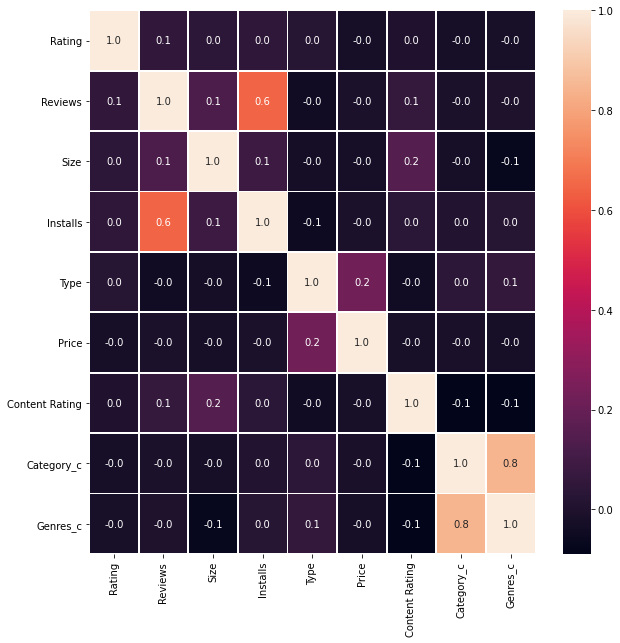

In [179]:
#correlation map
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(app.corr(), annot=True, linewidths=.9, fmt= '.1f',ax=ax)
plt.show()

Text(0.5, 1.0, 'Distribution of Rating')

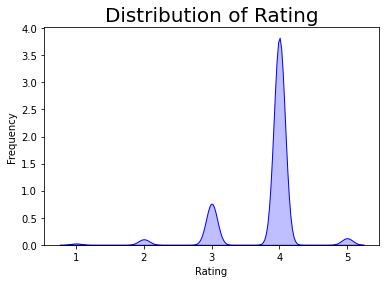

In [ ]:
g = sns.kdeplot(app.Rating, color="blue", shade = True)
g.set_xlabel("Rating")
g.set_ylabel("Frequency")
plt.title('Distribution of Rating',size = 20)

Text(0.5, 1.0, 'Count of app in each category')

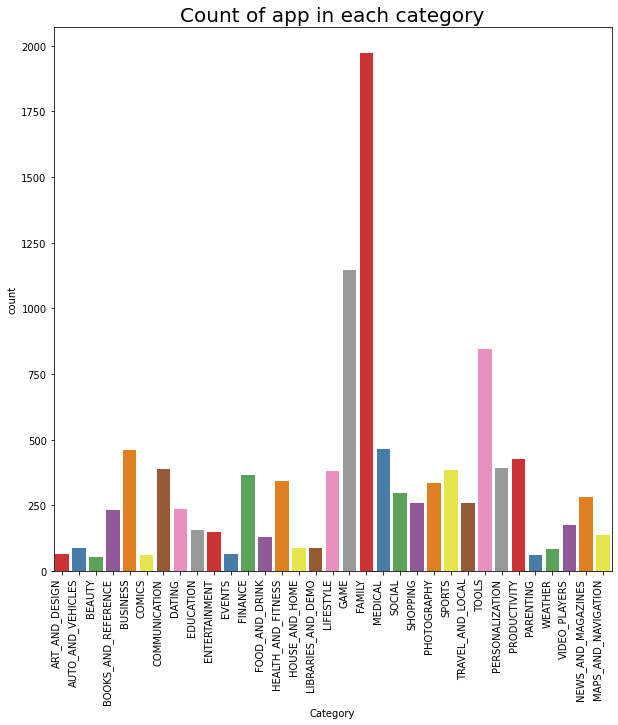

In [182]:
plt.figure(figsize = (10,10))
g = sns.countplot(x="Category",data=app, palette = "Set1")
g.set_xticklabels(g.get_xticklabels(), rotation=90, ha="right")
g 
plt.title('Count of app in each category',size = 20)

Text(0.5, 1.0, 'Boxplot of Rating VS Category')

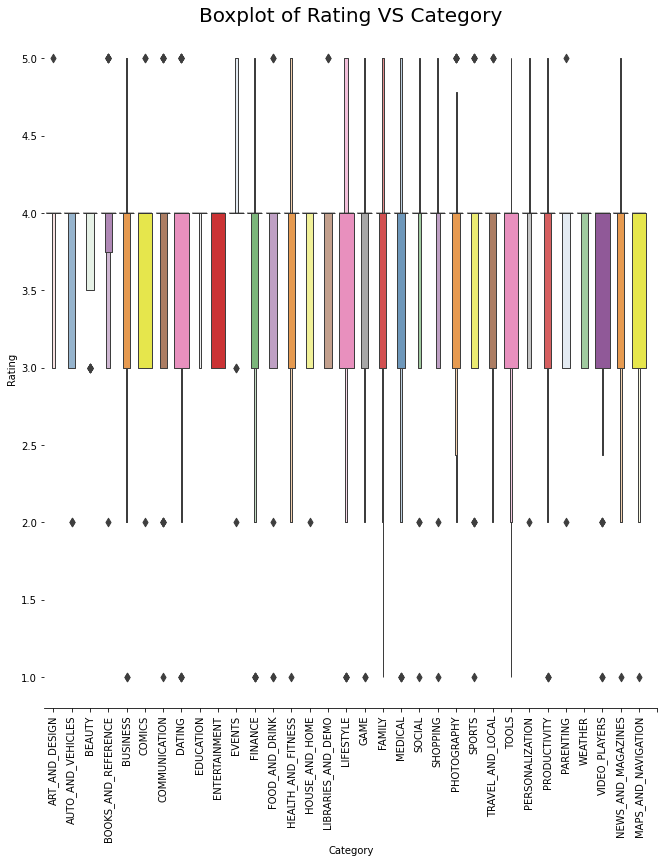

In [184]:
g = sns.catplot(x="Category",y="Rating",data=app, kind="boxen", height = 10,palette = "Set1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g.set( xticks=range(0,34))
g = g.set_ylabels("Rating")
plt.title('Boxplot of Rating VS Category',size = 20)

<Figure size 720x720 with 0 Axes>

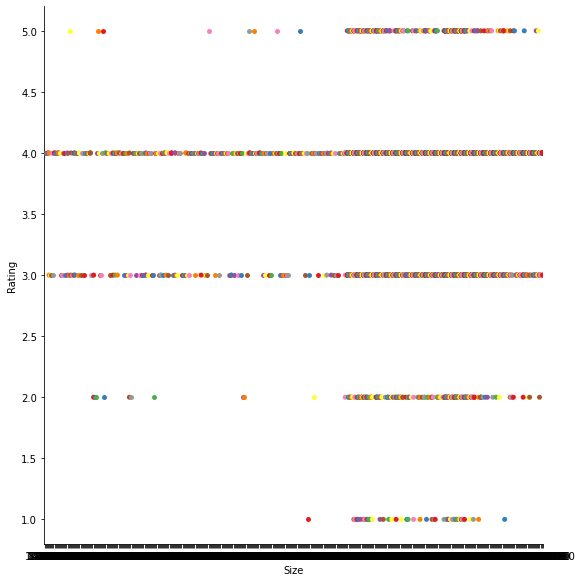

In [185]:
plt.figure(figsize = (10,10))
g = sns.catplot(x="Size", y="Rating",palette = "Set1", data=app, height = 8);

Text(0.5, 1.0, 'Scatter plot Rating VS Price')

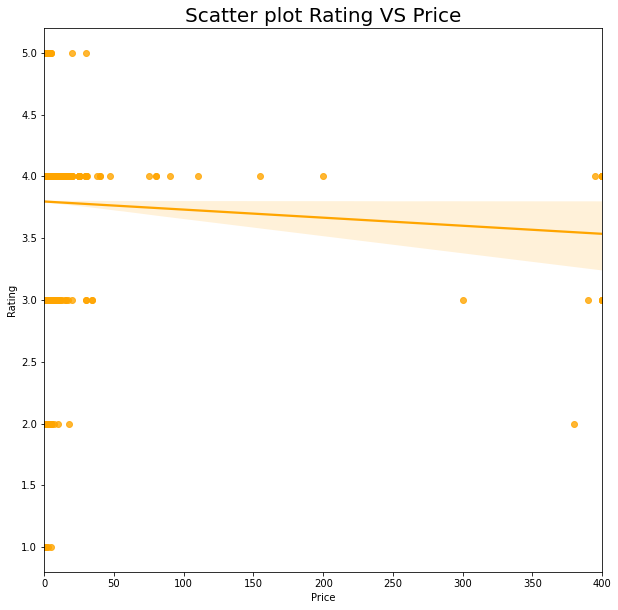

In [186]:
plt.figure(figsize = (10,10))
sns.regplot(x="Price", y="Rating", color = 'orange',data=app[app['Reviews']<1000000]);
plt.title('Scatter plot Rating VS Price',size = 20)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 100.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 97.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 89.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; 

Text(0.5, 1.0, 'Category in each Price VS Rating')

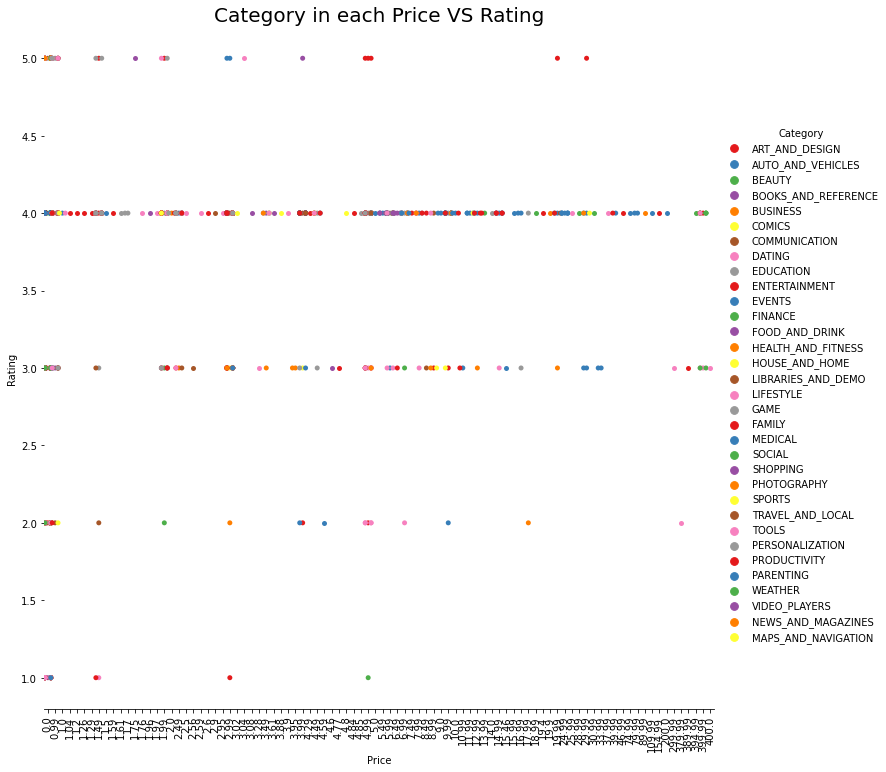

In [228]:
g = sns.catplot(x="Price", y="Rating", hue="Category", kind="swarm", data=app,palette = "Set1",height = 10)
g.despine(left=True)
g.set_xticklabels(rotation=90)
plt.title('Category in each Price VS Rating',size = 20)

Text(0.5, 1.0, 'Boxenplot of Rating VS Genres')

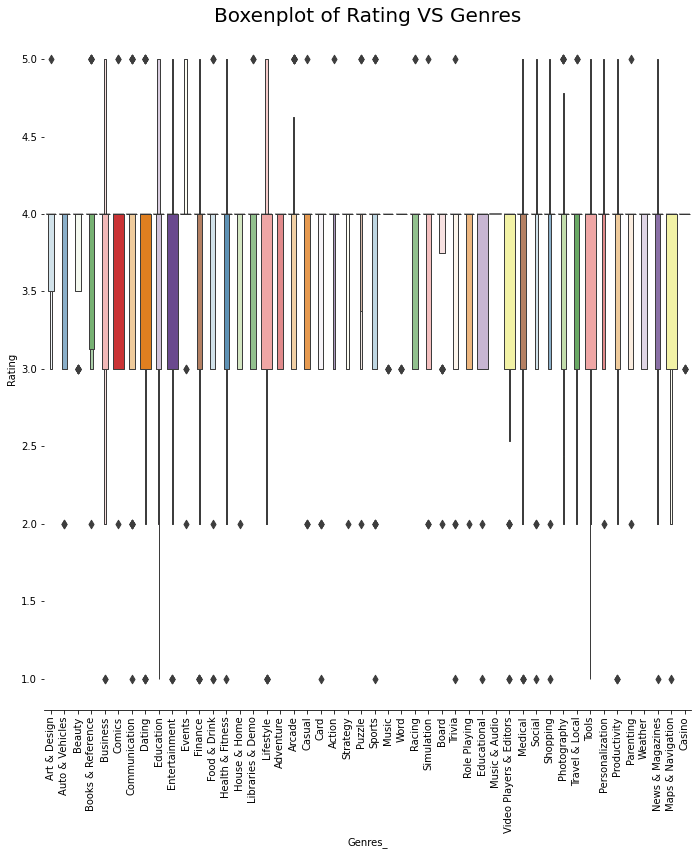

In [189]:
g = sns.catplot(x="Genres_",y="Rating",data=app, kind="boxen", height = 10 ,palette = "Paired")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Boxenplot of Rating VS Genres',size = 20)

# 3. Modeling (with minimal preprocessing) 

## 3.1. Using app_mean:

In [31]:
data = app_mean.values
X = app_mean.drop(['Category','Rating','Genres','Genres_','Genres_c'], axis=1)
X_col = X.columns
y = app_mean['Rating']
print(X.shape, y.shape)

(10840, 7) (10840,)


In [32]:
X.describe()

,Reviews,Size,Installs,Type,Price,Content Rating,Category_c
count,1.084000e+04,1.084000e+04,1.084000e+04,10840.000000,10840.000000,10840.000000,10840.000000
mean,4.441529e+05,2.151653e+07,1.546434e+07,0.073801,1.027368,0.327952,17.665129
std,2.927761e+06,2.074749e+07,8.502936e+07,0.261458,15.949703,0.761608,7.481603
min,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.800000e+01,5.900000e+06,1.000000e+03,0.000000,0.000000,0.000000,13.000000
50%,2.094000e+03,1.800000e+07,1.000000e+05,0.000000,0.000000,0.000000,18.000000
75%,5.477550e+04,2.600000e+07,5.000000e+06,0.000000,0.000000,0.000000,23.000000
max,7.815831e+07,1.000000e+08,1.000000e+09,1.000000,400.000000,5.000000,32.000000


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
 
    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train,res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train,  res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, res)))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("\nTest Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test,  res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,  res_test)))   

In [35]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'DecisionTree'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(y_true,y_predict))
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

### 3.1.1. Decision tree using app_mean

In [36]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
res_test = clf.predict(X_test)

In [37]:
#Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,res_test),orient = 'index')
resultsdf = resultsdf.transpose()

In [38]:
print_score(clf, X_train, X_test, y_train, y_test, train=True)
print_score(clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9997

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        42
           2       0.99      1.00      1.00       190
           3       1.00      1.00      1.00      1337
           4       1.00      1.00      1.00      6886
           5       1.00      1.00      1.00       217

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  42    0    0    0    0]
 [   0  190    0    0    0]
 [   0    0 1337    0    0]
 [   0    1    2 6883    0]
 [   0    0    0    0  217]]

Average Accuracy: 	 0.7141
Accuracy SD: 		 0.0115

Test Result:

accuracy score: 0.6850

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.09      0.12      0.10        41
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


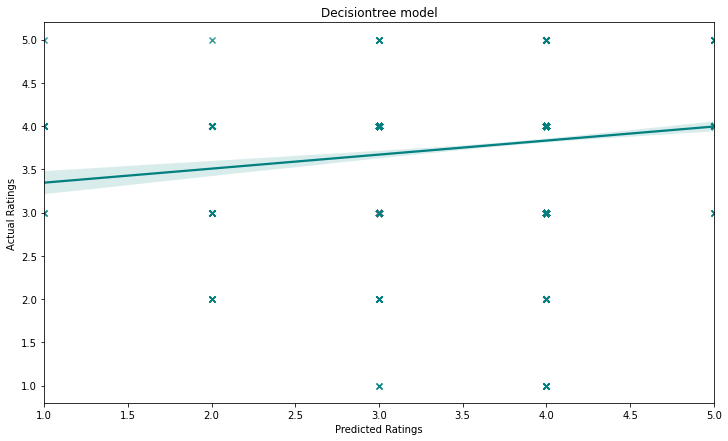

In [39]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Decisiontree model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.1.2. bagging using app_mean

In [40]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
res_test = bag_clf.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,res_test, name = 'Bagging'),ignore_index = True)

In [41]:
print_score(bag_clf, X_train, X_test, y_train, y_test, train=True)
print_score(bag_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9997

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        42
           2       1.00      0.99      1.00       190
           3       1.00      1.00      1.00      1337
           4       1.00      1.00      1.00      6886
           5       1.00      1.00      1.00       217

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  42    0    0    0    0]
 [   0  189    0    1    0]
 [   0    0 1336    1    0]
 [   0    0    1 6885    0]
 [   0    0    0    0  217]]

Average Accuracy: 	 0.7876
Accuracy SD: 		 0.0062

Test Result:

accuracy score: 0.7652

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.30      0.07      0.12        41
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


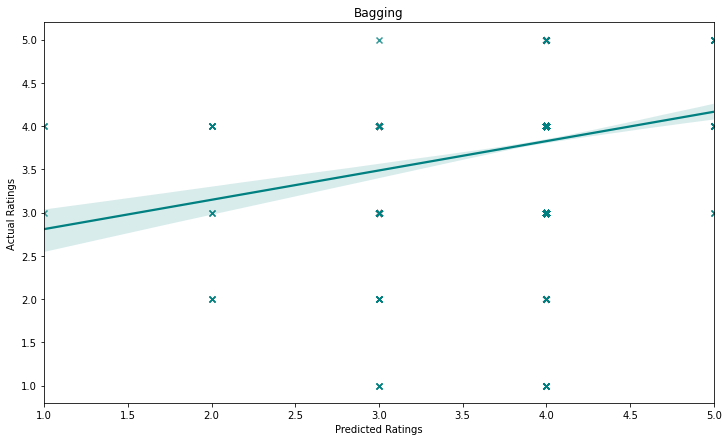

In [42]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Bagging')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.1.3. boosting - adaboost using app_mean

In [43]:
ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=1000,random_state=42)
ada_clf.fit(X_train, y_train)
res_test = ada_clf.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,res_test, name = 'Adaboost'),ignore_index = True)

In [44]:
print_score(ada_clf, X_train, X_test, y_train, y_test, train=True)
print_score(ada_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9997

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        42
           2       0.99      1.00      1.00       190
           3       1.00      1.00      1.00      1337
           4       1.00      1.00      1.00      6886
           5       1.00      1.00      1.00       217

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  42    0    0    0    0]
 [   0  190    0    0    0]
 [   0    0 1336    1    0]
 [   0    1    1 6884    0]
 [   0    0    0    0  217]]

Average Accuracy: 	 0.7855
Accuracy SD: 		 0.0065

Test Result:

accuracy score: 0.7601

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.25      0.07      0.11        41
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


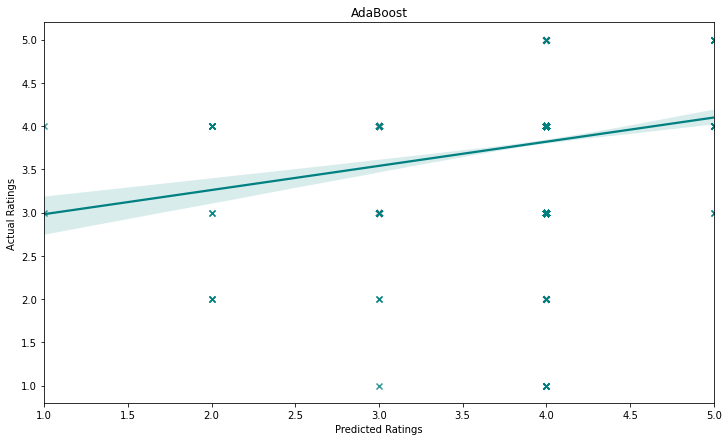

In [45]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('AdaBoost')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.1.4. Linear Regression using app_mean

In [46]:
def print_score_reg(clf, X_train, X_test, y_train, y_test, train=True):

    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("r2 score: {0:.4f}\n".format(r2_score(y_train,res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("\nTest Result:\n")        
        print("r2 score: {0:.4f}\n".format(r2_score(y_test, res_test)))

In [47]:
 lin_clf = LinearRegression()
lin_clf.fit(X_train, y_train)
res_test = lin_clf.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,res_test, name = 'Linear Regression'),ignore_index = True)

In [48]:
print_score_reg(lin_clf, X_train, X_test, y_train, y_test, train=True)
print_score_reg(lin_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

r2 score: 0.0059


Test Result:

r2 score: 0.0069



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


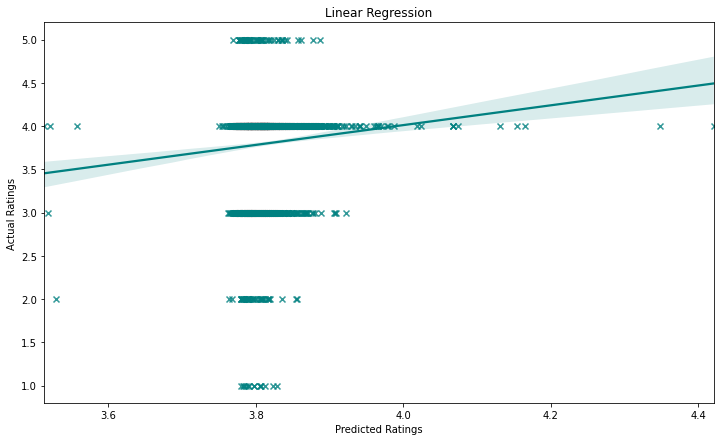

In [49]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Linear Regression')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.1.5. SVM using app_mean

In [50]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
res_test = svm_clf.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,res_test, name = 'SVM'),ignore_index = True)

In [51]:
print_score(svm_clf, X_train, X_test, y_train, y_test, train=True)
print_score(svm_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.7940

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        42
           2       0.00      0.00      0.00       190
           3       0.00      0.00      0.00      1337
           4       0.79      1.00      0.89      6886
           5       0.00      0.00      0.00       217

    accuracy                           0.79      8672
   macro avg       0.16      0.20      0.18      8672
weighted avg       0.63      0.79      0.70      8672


Confusion Matrix: 
 [[   0    0    0   42    0]
 [   0    0    0  190    0]
 [   0    0    0 1337    0]
 [   0    0    0 6886    0]
 [   0    0    0  217    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 	 0.7940
Accuracy SD: 		 0.0005

Test Result:

accuracy score: 0.7758

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00       374
           4       0.78      1.00      0.87      1682
           5       0.00      0.00      0.00        57

    accuracy                           0.78      2168
   macro avg       0.16      0.20      0.17      2168
weighted avg       0.60      0.78      0.68      2168


Confusion Matrix: 
 [[   0    0    0   14    0]
 [   0    0    0   41    0]
 [   0    0    0  374    0]
 [   0    0    0 1682    0]
 [   0    0    0   57    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


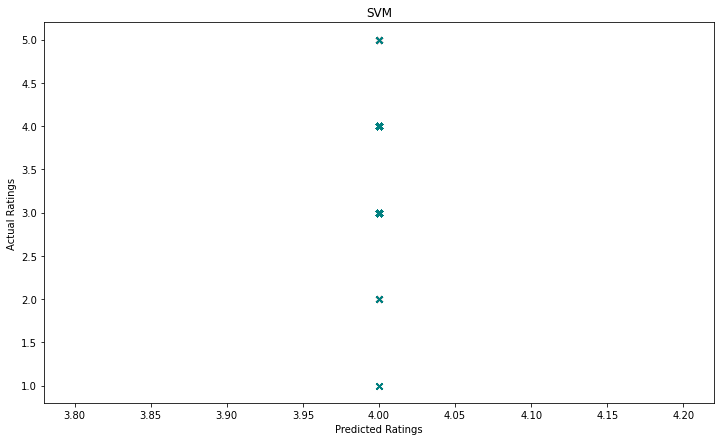

In [52]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('SVM')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.1.6. RandomForestClassifier using app_mean

In [53]:
rfr_clf = RandomForestClassifier()
rfr_clf.fit(X_train, y_train)
res_test = rfr_clf.predict(X_test)
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,res_test, name = 'Random Forest Classifier'),ignore_index = True)

In [54]:
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=True)
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9997

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        42
           2       1.00      0.99      1.00       190
           3       1.00      1.00      1.00      1337
           4       1.00      1.00      1.00      6886
           5       1.00      1.00      1.00       217

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  42    0    0    0    0]
 [   0  189    0    1    0]
 [   0    0 1336    1    0]
 [   0    0    1 6885    0]
 [   0    0    0    0  217]]

Average Accuracy: 	 0.7897
Accuracy SD: 		 0.0053

Test Result:

accuracy score: 0.7689

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.33      0.07      0.12        41
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


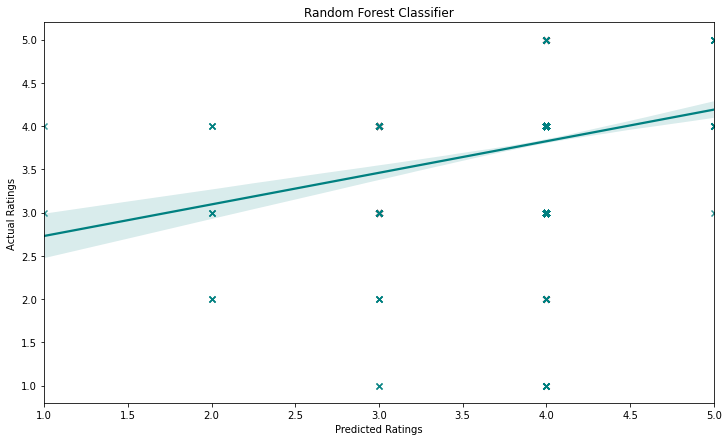

In [55]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Evaluation of models using app_mean

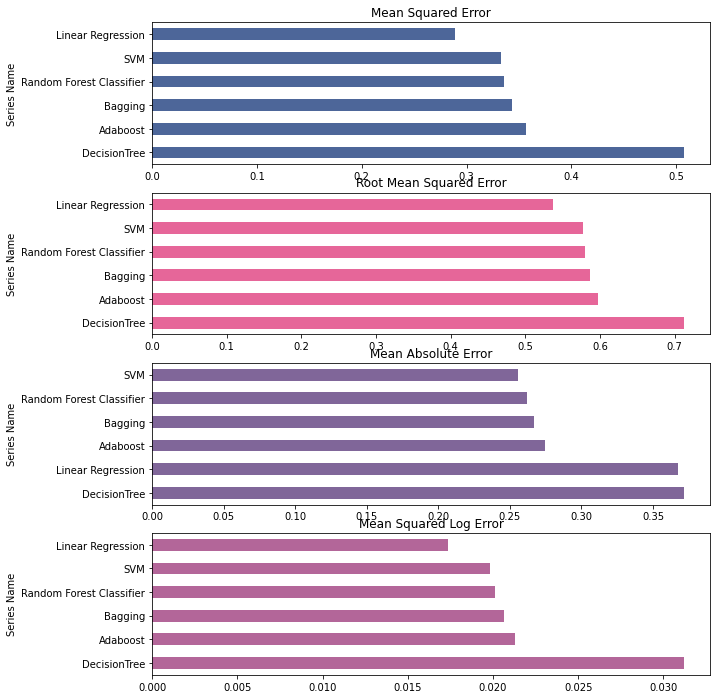

In [56]:
resultsdf.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(4,1,1)
resultsdf['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(4,1,2)
resultsdf['Root Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.9, 0.4, 0.6, 1), title = 'Root Mean Squared Error')
plt.subplot(4,1,3)
resultsdf['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(4,1,4)
resultsdf['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()


## 3.2. Using app_median:

In [57]:
data = app_med.values
X = app_med.drop(['Category','Rating','Genres','Genres_','Genres_c'], axis=1)
X_col = X.columns
y = app_med['Rating']
print(X.shape, y.shape)

(10840, 7) (10840,)


In [58]:
X.describe()

,Reviews,Size,Installs,Type,Price,Content Rating,Category_c
count,1.084000e+04,1.084000e+04,1.084000e+04,10840.000000,10840.000000,10840.000000,10840.000000
mean,4.441529e+05,2.151653e+07,1.546434e+07,0.073801,1.027368,0.327952,17.665129
std,2.927761e+06,2.074749e+07,8.502936e+07,0.261458,15.949703,0.761608,7.481603
min,0.000000e+00,8.500000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.800000e+01,5.900000e+06,1.000000e+03,0.000000,0.000000,0.000000,13.000000
50%,2.094000e+03,1.800000e+07,1.000000e+05,0.000000,0.000000,0.000000,18.000000
75%,5.477550e+04,2.600000e+07,5.000000e+06,0.000000,0.000000,0.000000,23.000000
max,7.815831e+07,1.000000e+08,1.000000e+09,1.000000,400.000000,5.000000,32.000000


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [60]:
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
 
    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train,res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train,  res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, res)))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("\nTest Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test,  res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,  res_test)))   

In [61]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Decision Tree'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(y_true,y_predict))
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

### 3.2.1 Decision Tree using app_med

In [62]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
res_test = clf.predict(X_test)

In [63]:
#Creation of results dataframe and addition of first entry
resultsdf_med = pd.DataFrame()
resultsdf_med = resultsdf_med.from_dict(Evaluationmatrix_dict(y_test,res_test),orient = 'index')
resultsdf_med = resultsdf_med.transpose()

In [64]:
print_score(clf, X_train, X_test, y_train, y_test, train=True)
print_score(clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       0.99      1.00      1.00       177
           3       1.00      1.00      1.00      1388
           4       1.00      1.00      1.00      6833
           5       1.00      1.00      1.00       227

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  47    0    0    0    0]
 [   0  177    0    0    0]
 [   0    0 1388    0    0]
 [   0    1    4 6828    0]
 [   0    0    0    0  227]]

Average Accuracy: 	 0.7040
Accuracy SD: 		 0.0084

Test Result:

accuracy score: 0.7279

Classification Report: 
               precision    recall  f1-score   support

           1       0.05      0.11      0.07         9
           2       0.12      0.11      0.11        54
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


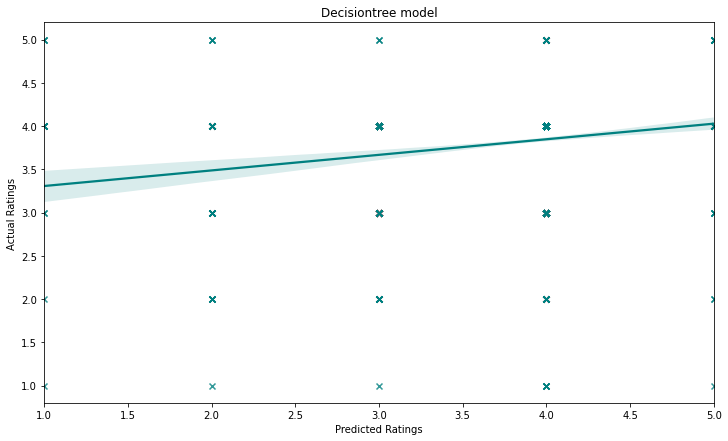

In [65]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Decisiontree model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.2.2.Bagging using app_med

In [66]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
res_test = bag_clf.predict(X_test)
resultsdf_med = resultsdf_med.append(Evaluationmatrix_dict(y_test,res_test, name = 'Bagging'),ignore_index = True)

In [67]:
print_score(bag_clf, X_train, X_test, y_train, y_test, train=True)
print_score(bag_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      0.99      1.00       177
           3       1.00      1.00      1.00      1388
           4       1.00      1.00      1.00      6833
           5       1.00      1.00      1.00       227

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  47    0    0    0    0]
 [   0  176    0    1    0]
 [   0    0 1384    4    0]
 [   0    0    0 6833    0]
 [   0    0    0    0  227]]

Average Accuracy: 	 0.7769
Accuracy SD: 		 0.0089

Test Result:

accuracy score: 0.7970

Classification Report: 
               precision    recall  f1-score   support

           1       0.20      0.11      0.14         9
           2       0.22      0.04      0.06        54
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


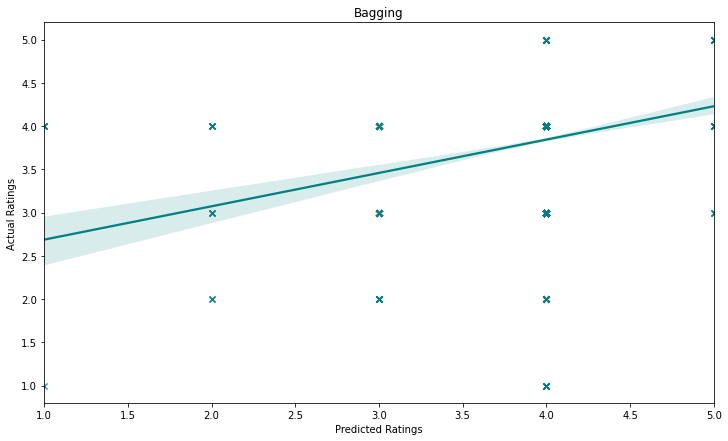

In [68]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Bagging')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.2.3 Boosting-Adaboost using app_med

In [69]:
ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=1000,random_state=42)
ada_clf.fit(X_train, y_train)
res_test = ada_clf.predict(X_test)
resultsdf_med = resultsdf_med.append(Evaluationmatrix_dict(y_test,res_test, name = 'Adaboost'),ignore_index = True)

In [70]:
print_score(ada_clf, X_train, X_test, y_train, y_test, train=True)
print_score(ada_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       0.99      1.00      1.00       177
           3       1.00      1.00      1.00      1388
           4       1.00      1.00      1.00      6833
           5       1.00      1.00      1.00       227

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  47    0    0    0    0]
 [   0  177    0    0    0]
 [   0    0 1387    1    0]
 [   0    1    3 6829    0]
 [   0    0    0    0  227]]

Average Accuracy: 	 0.7756
Accuracy SD: 		 0.0124

Test Result:

accuracy score: 0.7938

Classification Report: 
               precision    recall  f1-score   support

           1       0.25      0.11      0.15         9
           2       0.22      0.04      0.06        54
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


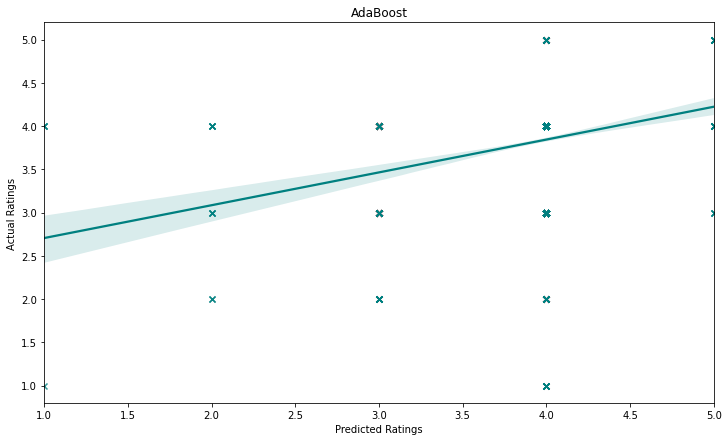

In [71]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('AdaBoost')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 3.2.3. Linear Regression

In [72]:
def print_score_reg(clf, X_train, X_test, y_train, y_test, train=True):

    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("r2 score: {0:.4f}\n".format(r2_score(y_train,res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("\nTest Result:\n")        
        print("r2 score: {0:.4f}\n".format(r2_score(y_test, res_test)))

In [73]:
lin_clf = LinearRegression()
lin_clf.fit(X_train, y_train)
res_test = lin_clf.predict(X_test)
resultsdf_med = resultsdf_med.append(Evaluationmatrix_dict(y_test,res_test, name = 'Linear Regression'),ignore_index = True)

In [74]:
print_score_reg(lin_clf, X_train, X_test, y_train, y_test, train=True)
print_score_reg(lin_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

r2 score: 0.0063


Test Result:

r2 score: 0.0059



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


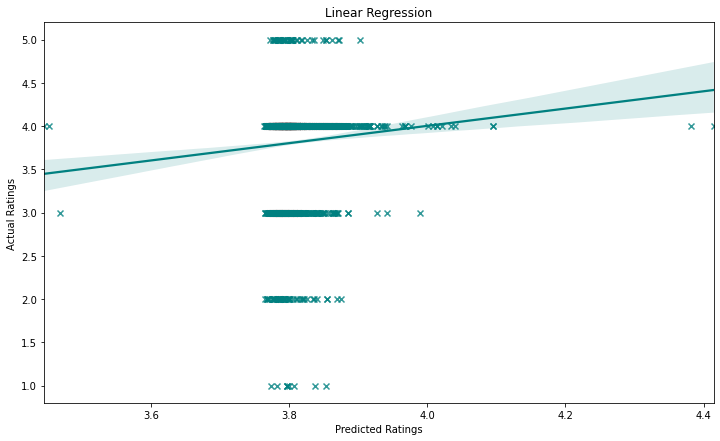

In [75]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Linear Regression')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### SVM

In [76]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
res_test = svm_clf.predict(X_test)
resultsdf_med = resultsdf_med.append(Evaluationmatrix_dict(y_test,res_test, name = 'SVM'),ignore_index = True)

In [77]:
print_score(svm_clf, X_train, X_test, y_train, y_test, train=True)
print_score(svm_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.7879

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00       177
           3       0.00      0.00      0.00      1388
           4       0.79      1.00      0.88      6833
           5       0.00      0.00      0.00       227

    accuracy                           0.79      8672
   macro avg       0.16      0.20      0.18      8672
weighted avg       0.62      0.79      0.69      8672


Confusion Matrix: 
 [[   0    0    0   47    0]
 [   0    0    0  177    0]
 [   0    0    0 1388    0]
 [   0    0    0 6833    0]
 [   0    0    0  227    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Accuracy: 	 0.7879
Accuracy SD: 		 0.0003

Test Result:

accuracy score: 0.8003

Classification Report: 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00       323
           4       0.80      1.00      0.89      1735
           5       0.00      0.00      0.00        47

    accuracy                           0.80      2168
   macro avg       0.16      0.20      0.18      2168
weighted avg       0.64      0.80      0.71      2168


Confusion Matrix: 
 [[   0    0    0    9    0]
 [   0    0    0   54    0]
 [   0    0    0  323    0]
 [   0    0    0 1735    0]
 [   0    0    0   47    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


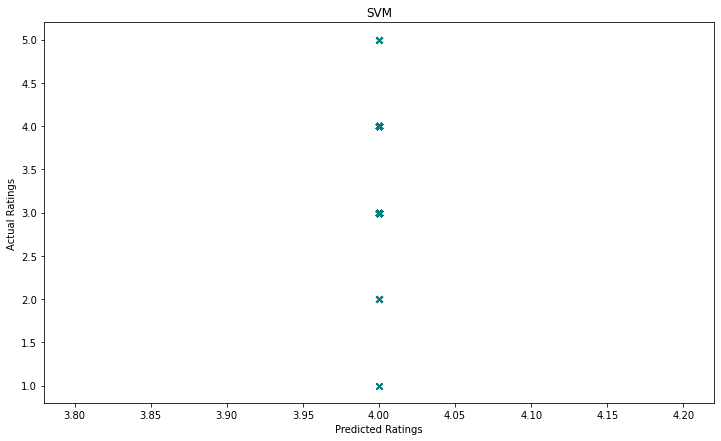

In [78]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('SVM')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Random Forest Classifier

In [79]:
rfr_clf = RandomForestClassifier()
rfr_clf.fit(X_train, y_train)
res_test = rfr_clf.predict(X_test)
resultsdf_med = resultsdf_med.append(Evaluationmatrix_dict(y_test,res_test, name = 'Random Forest Classifier'),ignore_index = True)

In [80]:
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=True)
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9993

Classification Report: 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      0.99      1.00       177
           3       1.00      1.00      1.00      1388
           4       1.00      1.00      1.00      6833
           5       1.00      1.00      1.00       227

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[  47    0    0    0    0]
 [   0  176    0    1    0]
 [   0    0 1384    4    0]
 [   0    0    1 6832    0]
 [   0    0    0    0  227]]

Average Accuracy: 	 0.7824
Accuracy SD: 		 0.0110

Test Result:

accuracy score: 0.7984

Classification Report: 
               precision    recall  f1-score   support

           1       0.25      0.11      0.15         9
           2       0.20      0.04      0.06        54
       

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


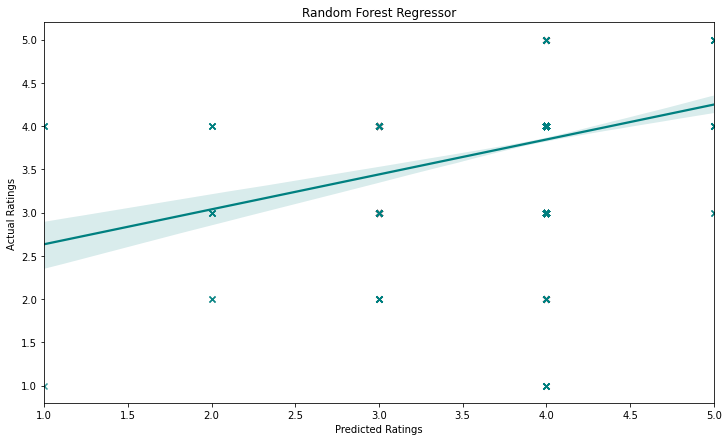

In [81]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Random Forest Regressor')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Evaluation of models using app_med

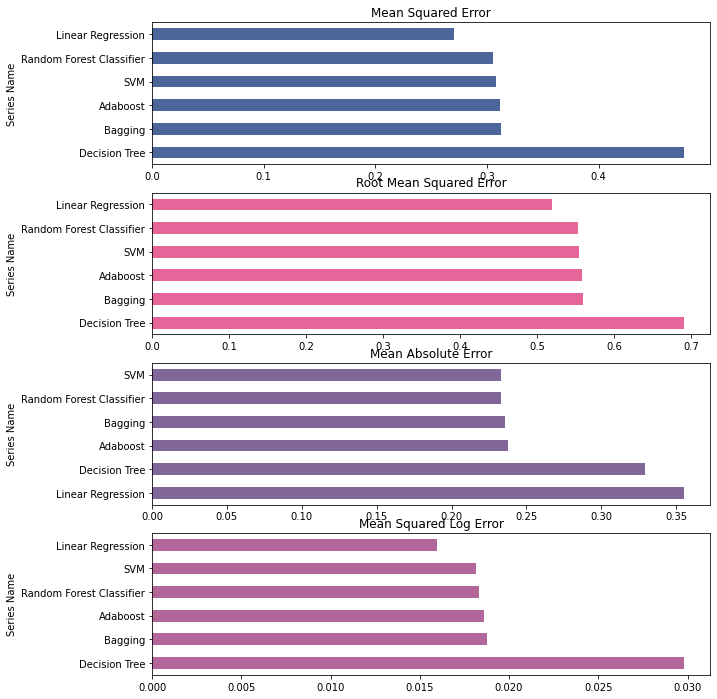

In [82]:
resultsdf_med.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(4,1,1)
resultsdf_med['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(4,1,2)
resultsdf_med['Root Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.9, 0.4, 0.6, 1), title = 'Root Mean Squared Error')
plt.subplot(4,1,3)
resultsdf_med['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(4,1,4)
resultsdf_med['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()

# 4. Preprocessing:

In [191]:
app_new=pd.read_csv('/content/files/googleplaystore.csv')
app_new.drop(app.loc[app['Installs']=='Free'].index, inplace=True)

## Handling missing values:

In [192]:
#dropping of unrelated and unnecessary items
app_new.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [193]:
app_new.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
dtype: int64

In [194]:
#for continous data:
app_new['Rating']=app_new['Rating'].replace(np.NaN, app_new['Rating'].mean())
app_new.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    1
Genres            0
dtype: int64

In [195]:
#for catagorical data:
app_new['Type'].fillna(str(app_new.Type.mode().values[0]), inplace=True)
app_new['Content Rating'].fillna(str(app_new['Content Rating'].mode().values[0]), inplace=True)
app_new.select_dtypes(include='object').isnull().sum()

Category          0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
dtype: int64

## 4.1. Encoding:

### LabelEncoding:

In [196]:
app_obj = app_new.select_dtypes(include=['object'])
col_name = app_obj.columns
app_obj.head()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,ART_AND_DESIGN,159,19M,"10,000+",Free,0,Everyone,Art & Design
1,ART_AND_DESIGN,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play
2,ART_AND_DESIGN,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design
3,ART_AND_DESIGN,215644,25M,"50,000,000+",Free,0,Teen,Art & Design
4,ART_AND_DESIGN,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity


In [197]:
#Encoding Without Rating feature
le = preprocessing.LabelEncoder()
app_le = app_new
for i in app_obj:
    app_le[i] = le.fit_transform(app_le[i])
app_le.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,1,4.1,1182,54,7,1,91,1,9
1,1,3.9,5923,28,19,1,91,1,12
2,1,4.7,5680,367,14,1,91,1,9
3,1,4.5,1946,100,17,1,91,4,9
4,1,4.3,5923,63,10,1,91,1,11


In [198]:
#Encoding With Rating feature
le = preprocessing.LabelEncoder()
app_new_le = app_new
for i in app_new:
    app_new_le[i] = le.fit_transform(app_new_le[i])
app_new_le.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,1,29,1182,54,7,1,91,1,9
1,1,27,5923,28,19,1,91,1,12
2,1,36,5680,367,14,1,91,1,9
3,1,34,1946,100,17,1,91,4,9
4,1,32,5923,63,10,1,91,1,11


### Scaler:

4.1. MinMaxScaler

In [199]:
mms = preprocessing.MinMaxScaler()
app_mms = app_new_le
app_mms[["Rating"]] = mms.fit_transform(app_new_le[["Rating"]])
app_mms.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,1,0.725,1182,54,7,1,91,1,9
1,1,0.675,5923,28,19,1,91,1,12
2,1,0.900,5680,367,14,1,91,1,9
3,1,0.850,1946,100,17,1,91,4,9
4,1,0.800,5923,63,10,1,91,1,11


4.2. RobustScaler

In [200]:
rs = preprocessing.RobustScaler()
app_rs = app_new_le
app_rs[["Rating"]] = mms.fit_transform(app_new_le[["Rating"]])
app_rs.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,1,0.725,1182,54,7,1,91,1,9
1,1,0.675,5923,28,19,1,91,1,12
2,1,0.900,5680,367,14,1,91,1,9
3,1,0.850,1946,100,17,1,91,4,9
4,1,0.800,5923,63,10,1,91,1,11


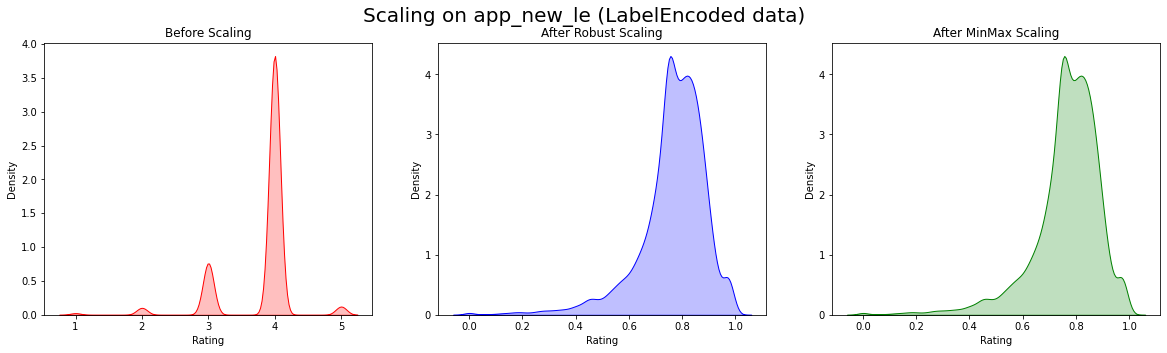

In [201]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize =(20, 5)) 
ax1.set_title('Before Scaling') 
sns.kdeplot(app['Rating'], ax = ax1, color ='r',shade = True)
ax2.set_title('After Robust Scaling') 
sns.kdeplot(app_rs['Rating'], ax = ax2, color ='b',shade = True)
ax3.set_title('After MinMax Scaling') 
sns.kdeplot(app_mms['Rating'], ax = ax3, color ='g',shade = True)
fig.suptitle('Scaling on app_new_le (LabelEncoded data)', fontsize=20)
plt.show() 

# 5. Modeling:

## 5.1. Using app_le (without scaling class label) 

In [202]:
data = app_le.values
X = app_le.drop(['Rating'], axis=1)
X_col = X.columns
y = app_le['Rating'].astype(int)
print(X.shape, y.shape)

(10841, 8) (10841,)


In [203]:
X.describe()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres
count,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000
mean,17.723734,2743.178581,207.759155,9.487317,1.073702,87.083756,1.464994,64.875842
std,8.354659,1836.390479,155.533112,4.826229,0.261650,15.974253,1.006114,33.059316
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1156.000000,71.000000,6.000000,1.000000,91.000000,1.000000,38.000000
50%,15.000000,2746.000000,167.000000,9.000000,1.000000,91.000000,1.000000,68.000000
75%,26.000000,4319.000000,344.000000,13.000000,1.000000,91.000000,1.000000,97.000000
max,33.000000,6001.000000,461.000000,21.000000,2.000000,92.000000,5.000000,119.000000


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [205]:
def print_score(clf, X_train, X_test, y_train, y_test, train=True):

    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train,res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train,  res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, res)))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test,  res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,  res_test)))   

In [207]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Decision Tree'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(y_true,y_predict))
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

### 5.1.1. Decision Tree 

In [208]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
res_test = clf.predict(X_test)

In [209]:
#Creation of results dataframe and addition of first entry
resultsdf_mms = pd.DataFrame()
resultsdf_mms = resultsdf_mms.from_dict(Evaluationmatrix_dict(y_test,res_test),orient = 'index')
resultsdf_mms = resultsdf_mms.transpose()

In [210]:
print_score(clf, X_train, X_test, y_train, y_test, train=True)
print_score(clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8671
           1       1.00      1.00      1.00         1

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8671    0]
 [   0    1]]

Average Accuracy: 	 0.9999
Accuracy SD: 		 0.0003
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2169]]



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


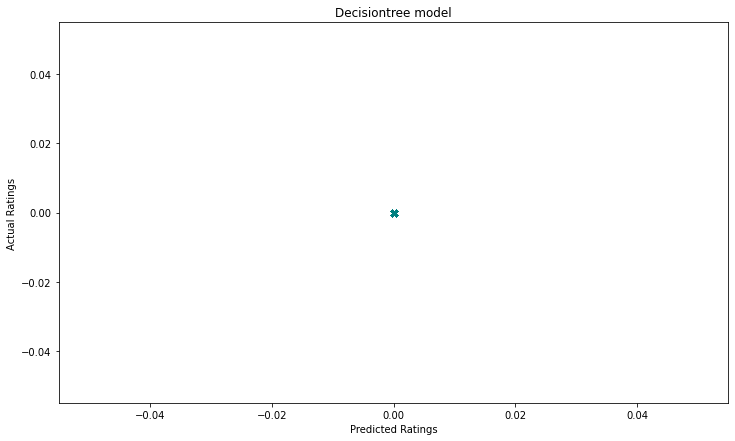

In [211]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Decisiontree model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.1.3. SVM

In [212]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
res_test = svm_clf.predict(X_test)
resultsdf_mms = resultsdf_mms.append(Evaluationmatrix_dict(y_test,res_test, name = 'SVM'),ignore_index = True)

In [213]:
print_score(svm_clf, X_train, X_test, y_train, y_test, train=True)
print_score(svm_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 0.9999

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8671
           1       0.00      0.00      0.00         1

    accuracy                           1.00      8672
   macro avg       0.50      0.50      0.50      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8671    0]
 [   1    0]]

Average Accuracy: 	 nan
Accuracy SD: 		 nan
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2169]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The number of classes has to be greater than one; got 1 class

  FitFailedWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


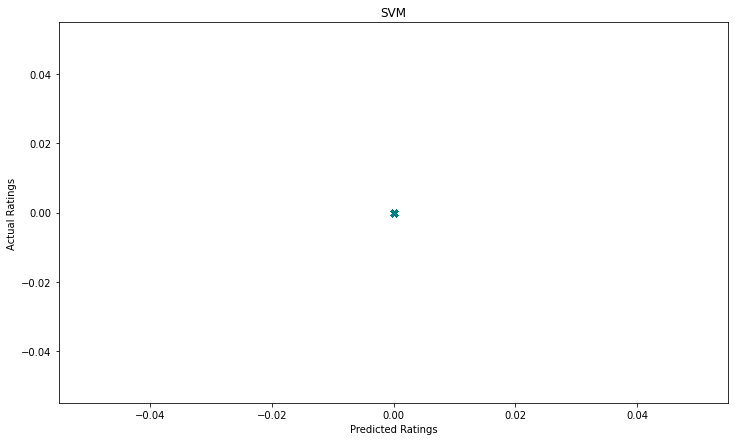

In [214]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('SVM')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.1.4. Random Forest Classifier

In [215]:
rfr_clf = RandomForestClassifier()
rfr_clf.fit(X_train, y_train)
res_test = rfr_clf.predict(X_test)
resultsdf_mms = resultsdf_mms.append(Evaluationmatrix_dict(y_test,res_test, name = 'Random Forest Classifier'),ignore_index = True)

In [216]:
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=True)
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8671
           1       1.00      1.00      1.00         1

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8671    0]
 [   0    1]]



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Average Accuracy: 	 0.9999
Accuracy SD: 		 0.0003
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2169]]



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


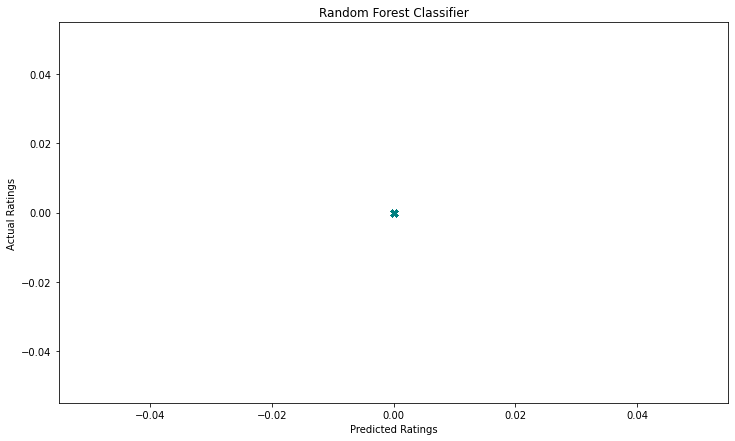

In [217]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.1.5.(A) Bagging (with DecisionTree)

In [218]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
res_test = bag_clf.predict(X_test)
resultsdf_mms = resultsdf_mms.append(Evaluationmatrix_dict(y_test,res_test, name = 'Bagging (with DT)'),ignore_index = True)

In [219]:
print_score(bag_clf, X_train, X_test, y_train, y_test, train=True)
print_score(bag_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8671
           1       1.00      1.00      1.00         1

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8671    0]
 [   0    1]]



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Average Accuracy: 	 0.9999
Accuracy SD: 		 0.0003
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2169]]



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


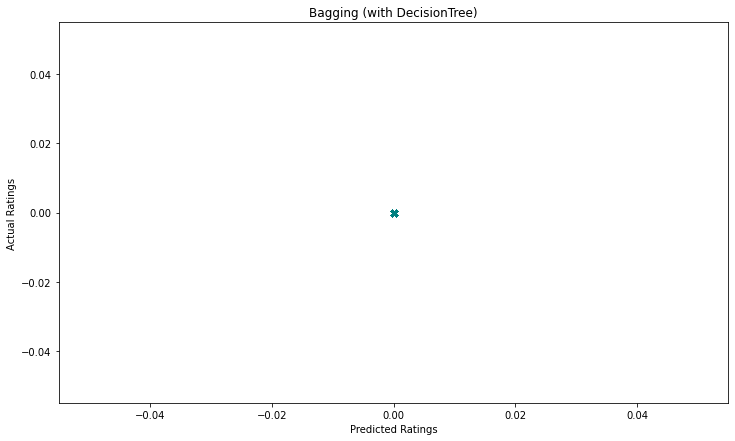

In [220]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Bagging (with DecisionTree)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.1.6.(A) Boosting - Adaboost (with DecisionTree)

In [221]:
ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=1000,random_state=42)
ada_clf.fit(X_train, y_train)
res_test = ada_clf.predict(X_test)
resultsdf_mms = resultsdf_mms.append(Evaluationmatrix_dict(y_test,res_test, name = 'Adaboost (with DT)'),ignore_index = True)

In [222]:
print_score(ada_clf, X_train, X_test, y_train, y_test, train=True)
print_score(ada_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8671
           1       1.00      1.00      1.00         1

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8671    0]
 [   0    1]]

Average Accuracy: 	 0.9999
Accuracy SD: 		 0.0003
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2169

    accuracy                           1.00      2169
   macro avg       1.00      1.00      1.00      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2169]]



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


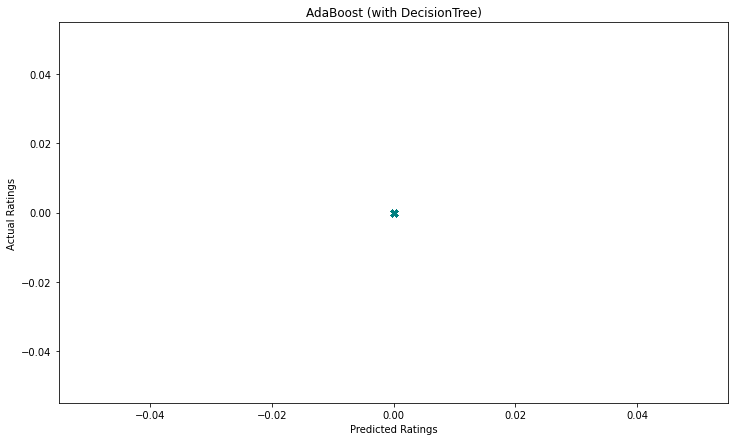

In [223]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('AdaBoost (with DecisionTree)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Evaluation of models 


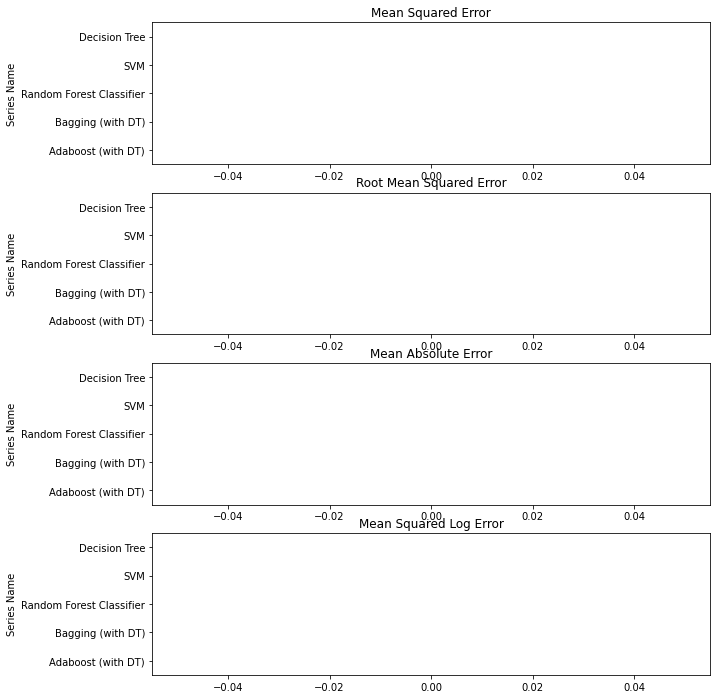

In [227]:
resultsdf_mms.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(4,1,1)
resultsdf_mms['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(4,1,2)
resultsdf_mms['Root Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.9, 0.4, 0.6, 1), title = 'Root Mean Squared Error')
plt.subplot(4,1,3)
resultsdf_mms['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(4,1,4)
resultsdf_mms['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()

## 5.2. Using app_rs (scaling class label with RobustScaler)

In [117]:
data = app_rs.values
X = app_rs.drop(['Rating'], axis=1)
X_col = X.columns
y = app_rs['Rating'].astype(int)
print(X.shape, y.shape)

(10841, 8) (10841,)


In [118]:
X.describe()

,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres
count,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000,10841.000000
mean,17.723734,2743.178581,207.759155,9.487317,1.073702,87.083756,1.464994,64.875842
std,8.354659,1836.390479,155.533112,4.826229,0.261650,15.974253,1.006114,33.059316
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,1156.000000,71.000000,6.000000,1.000000,91.000000,1.000000,38.000000
50%,15.000000,2746.000000,167.000000,9.000000,1.000000,91.000000,1.000000,68.000000
75%,26.000000,4319.000000,344.000000,13.000000,1.000000,91.000000,1.000000,97.000000
max,33.000000,6001.000000,461.000000,21.000000,2.000000,92.000000,5.000000,119.000000


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [120]:
def print_score(clf, X_train, X_test, y_train, y_test, train=True):

    if train:
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train,res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train,  res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, res)))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test,  res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test,  res_test)))   

In [121]:
#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Decision Tree'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Root Mean Squared Error'] = np.sqrt(metrics.mean_squared_error(y_true,y_predict))
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

### 5.2.1. Decision Tree

In [122]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
res_test = clf.predict(X_test)

In [123]:
#Creation of results dataframe and addition of first entry
resultsdf_rs = pd.DataFrame()
resultsdf_rs = resultsdf_rs.from_dict(Evaluationmatrix_dict(y_test,res_test),orient = 'index')
resultsdf_rs = resultsdf_rs.transpose()

In [124]:
print_score(clf, X_train, X_test, y_train, y_test, train=True)
print_score(clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8672

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8672]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
Test Result:

accuracy score: 0.9995

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2168
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2169
   macro avg       0.50      0.50      0.50      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2168    0]
 [   1    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


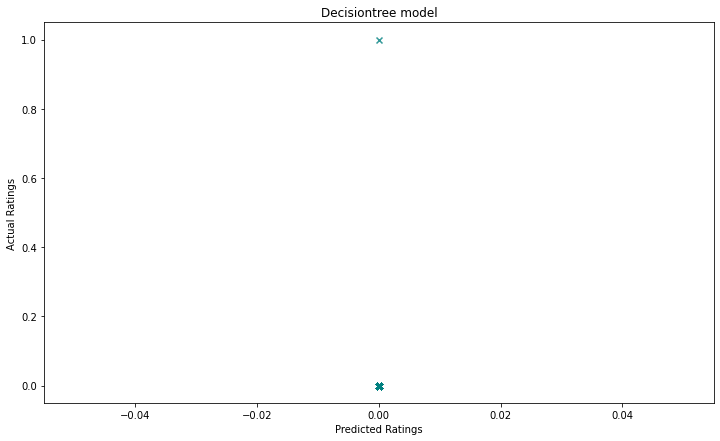

In [125]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Decisiontree model')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.2.2. SVM

In [131]:
svm_clf = svm.SVR()
svm_clf.fit(X_train, y_train)
res_test = svm_clf.predict(X_test)
resultsdf_rs = resultsdf_rs.append(Evaluationmatrix_dict(y_test,res_test, name = 'SVM'),ignore_index = True)

In [132]:
print_score(svm_clf, X_train, X_test, y_train, y_test, train=True)
print_score(svm_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8672

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8672]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
Test Result:

accuracy score: 0.9995

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2168
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2169
   macro avg       0.50      0.50      0.50      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2168    0]
 [   1    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


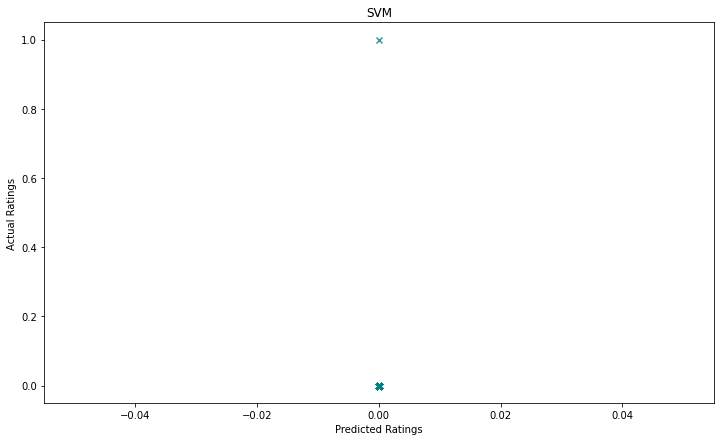

In [133]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('SVM')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.2.3. Random Forest Classifier

In [134]:
rfr_clf = RandomForestClassifier()
rfr_clf.fit(X_train, y_train)
res_test = rfr_clf.predict(X_test)
resultsdf_rs = resultsdf_rs.append(Evaluationmatrix_dict(y_test,res_test, name = 'Random Forest Classifier'),ignore_index = True)

In [135]:
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=True)
print_score(rfr_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8672

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8672]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
Test Result:

accuracy score: 0.9995

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2168
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2169
   macro avg       0.50      0.50      0.50      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2168    0]
 [   1    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


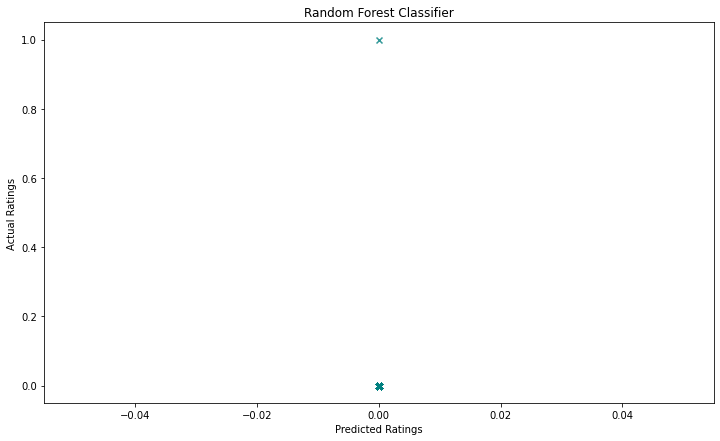

In [136]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Random Forest Classifier')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.2.4. BaggingClassifier (with DecisionTree)

In [137]:
bag_clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                            bootstrap=True, oob_score=True,
                            n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
res_test = bag_clf.predict(X_test)
resultsdf_rs = resultsdf_rs.append(Evaluationmatrix_dict(y_test,res_test, name = 'Bagging (with DT)'),ignore_index = True)

In [138]:
print_score(bag_clf, X_train, X_test, y_train, y_test, train=True)
print_score(bag_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8672

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8672]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
Test Result:

accuracy score: 0.9995

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2168
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2169
   macro avg       0.50      0.50      0.50      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2168    0]
 [   1    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


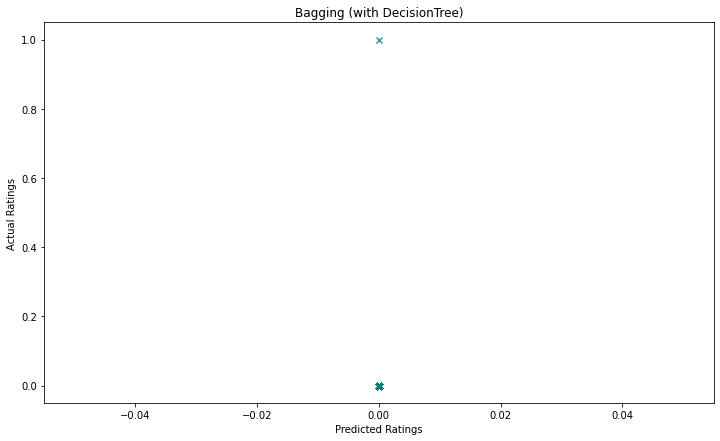

In [139]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('Bagging (with DecisionTree)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### 5.2.5. Boosting - Adaboost (with DecisionTree)

In [140]:
ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=1000,random_state=42)
ada_clf.fit(X_train, y_train)
res_test = ada_clf.predict(X_test)
resultsdf_rs = resultsdf_rs.append(Evaluationmatrix_dict(y_test,res_test, name = 'Adaboost (with DT)'),ignore_index = True)

In [141]:
print_score(ada_clf, X_train, X_test, y_train, y_test, train=True)
print_score(ada_clf, X_train, X_test, y_train, y_test, train=False)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8672

    accuracy                           1.00      8672
   macro avg       1.00      1.00      1.00      8672
weighted avg       1.00      1.00      1.00      8672


Confusion Matrix: 
 [[8672]]

Average Accuracy: 	 1.0000
Accuracy SD: 		 0.0000
Test Result:

accuracy score: 0.9995

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2168
           1       0.00      0.00      0.00         1

    accuracy                           1.00      2169
   macro avg       0.50      0.50      0.50      2169
weighted avg       1.00      1.00      1.00      2169


Confusion Matrix: 
 [[2168    0]
 [   1    0]]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


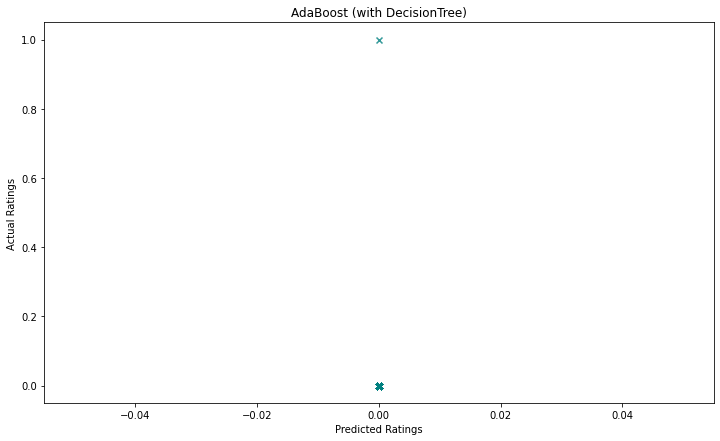

In [142]:
plt.figure(figsize=(12,7))
sns.regplot(res_test,y_test,color='teal', marker = 'x')
plt.title('AdaBoost (with DecisionTree)')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

### Evaluation of models using app_rs

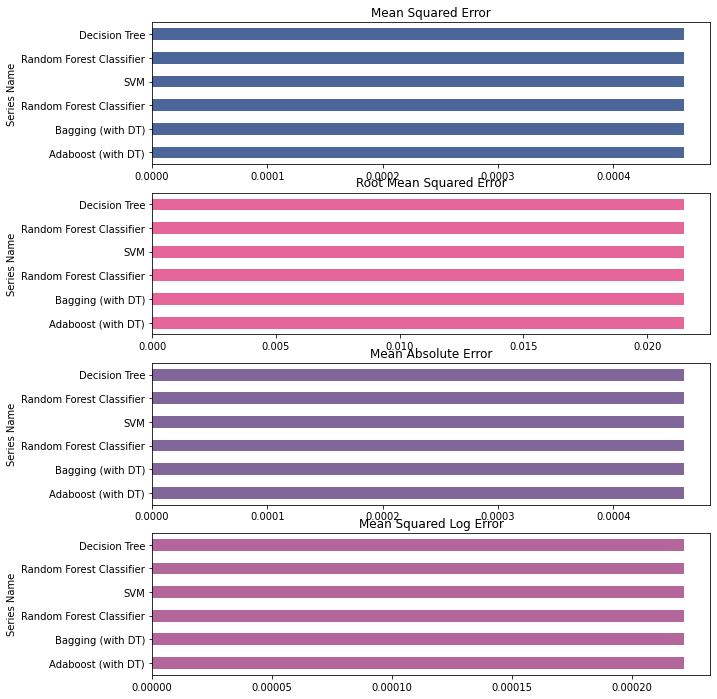

In [143]:
resultsdf_rs.set_index('Series Name', inplace = True)

plt.figure(figsize = (10,12))
plt.subplot(4,1,1)
resultsdf_rs['Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.3, 0.4, 0.6, 1), title = 'Mean Squared Error')
plt.subplot(4,1,2)
resultsdf_rs['Root Mean Squared Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.9, 0.4, 0.6, 1), title = 'Root Mean Squared Error')
plt.subplot(4,1,3)
resultsdf_rs['Mean Absolute Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.5, 0.4, 0.6, 1), title = 'Mean Absolute Error')
plt.subplot(4,1,4)
resultsdf_rs['Mean Squared Log Error'].sort_values(ascending = False).plot(kind = 'barh',color=(0.7, 0.4, 0.6, 1), title = 'Mean Squared Log Error')
plt.show()